# How does annual summed GPP compare with annual NDVI? 

Looking to understand the correlation between annual productivity (annual sum of GPP) and the annual sum of NDVI to validate if the intergal-of-season NDVI metric relates to overall productivity in Australia.

Its difficult to match GPP IOS with NDVI IOS because even small differences in the shape and timings of the annual curve can result in a large difference in IOS, therefore we simplify by comparing annual sums.

For flux tower GPP, we extract monthly means and then upscale to daily using exactly the same procedures as the NDVI curves to increase comparability.

To again increase comparaibility between NDVI and flux tower GPP, we use 1 km resolution MODIS MCD43A4 NDVI instead of the 5km resolution AusENDVI as a 5 x 5 km pixel can have much less correspondence with tower footprints than 1 x 1km pixels. AusENDVI uses MODIS MCD43A4 NDVI from 2000 onwards so its effectively the same data, just higher resolution.

In [1]:
%matplotlib inline

import os
import sys
import pingouin as pg
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import distinctipy
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.simplefilter(action='ignore')

# import sys
# sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')

In [2]:
def filter_complete_years(ds):
    # Extract year and month information
    df = ds.time.to_dataframe().reset_index(drop=True)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12] # Keep only years with exactly 12 unique months
        .index
    )
    
    # Filter the data array to include only these complete years
    filtered_data = ds.where(ds.time.dt.year.isin(complete_years), drop=True)
    
    return filtered_data

## Flux towers

### Get flux data


In [3]:
# ds = extract_ozflux(version='2023_v1',
#                         level='L6',
#                         type='default',
#                         timestep='Monthly',
#                         # rs_data_folder='/g/data/os22/chad_tmp/AusEFlux/data/5km/',
#                         # save_ec_data='/g/data/os22/chad_tmp/AusEFlux/data/ozflux_netcdf/',
#                         return_coords=True,
#                         verbose=False,
#                         export_path='/g/data/os22/chad_tmp/Aus_phenology/data/ozflux/'
#                         )

In [4]:
base = '/g/data/os22/chad_tmp/Aus_phenology/'
sites = os.listdir(f'{base}data/ozflux/')
# homogenous = ['AliceSpringsMulga','DalyUncleared','RobsonCreek','CowBay', 'CapeTribulation',
#               'DryRiver','Gingin','RiggsCreek','TiTreeEast',
#               'Tumbarumba','WombatStateForest','Whroo'
#              ]

flux_ts = {}
for site in sites:
    if '.csv' in site:
        # if any(h in site for h in homogenous): #only homogenous sites
        # print(site[0:-4])
        xx = pd.read_csv(f'{base}data/ozflux/{site}',
                         index_col='time', parse_dates=True)

        #convert to 1d xarray
        lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
        xx = xx[['GPP_SOLO_EC']]  #'x_coord', 'y_coord'
        xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
        xx = xx['GPP_SOLO_EC'].squeeze()
        xx['time'] = xx.time.astype('datetime64[D]')
        flux_ts[site[0:-4]] = xx
        # else:
        #     continue

### Exclude some sites

Due to to very short time-series, cropping, other issues

In [5]:
flux_ts.pop('Fletcherview', None)
flux_ts.pop('Emerald', None)
flux_ts.pop('Loxton', None)
flux_ts.pop('FoggDam', None)
flux_ts.pop('Collie', None)
flux_ts.pop('RedDirtMelonFarm', None)
flux_ts.pop('SilverPlains', None)
flux_ts.pop('Otway', None)
flux_ts.pop('Ridgefield', None);
# del my_dict['key']

#### Open NDVI data

In [6]:
path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/NDVI_1km.nc'
ds = xr.open_dataset(path)
ds = ds['NDVI']

# 500m OzWALD NDVI
# base = '/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/ozwald_ndvi/'
# files = [f'{base}/{i}' for i in os.listdir(base) if i.endswith(".nc")]
# files.sort()
# # #combine annual files into one file
# ds = xr.open_mfdataset(files).sel(time=slice('2001', '2022')).rename({'__xarray_dataarray_variable__':'NDVI'})
# ds = ds['NDVI']

# subtract soil signal
ndvi_min_path =f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_1km.nc'
ndvi_min = xr.open_dataset(ndvi_min_path)['NDVI']
ds = ds - ndvi_min #bare soil value
ds.name = 'NDVI'

#### Process timeseries and calculate phenometrics

In [7]:
flux_tss = {}
ndvi_tss = {}
annual_gpp = {}
annual_ndvi = {}

for k,v in flux_ts.items():
    print(k)
    
    # Index NDVI at location and time so we have matching time series
    lat,lon = v.latitude, v.longitude
    ndvi = ds.sel(latitude=lat, longitude=lon, method='nearest')

    #remove incomplete years
    v = filter_complete_years(v)

    # make sure GPP never extends beyond the range of NDVI
    v = v.sel(time=slice('2003', '2022'))

    #match NDVI time with GPP time
    ndvi = ndvi.sel(time=v.time, method='nearest',tolerance='1D').compute()
    ndvi = ndvi.interpolate_na(dim='time', method='linear', limit=2) #get rid of any NaNs

    if k == 'WallabyCreek': # avoid the fire
        v = v.sel(time=slice('2005', '2008'))
        ndvi = ndvi.sel(time=slice('2005', '2008'))

    assert np.sum(v.time == ndvi.time) == len(v.time) 

    # #smooth both datasets
    # ndvi = ndvi.resample(time="2W").interpolate("linear")
    # v = v.resample(time="2W").interpolate("linear")
    # ndvi=sg_smooth(ndvi,window=11, poly=3, deriv=0)
    # v=sg_smooth(v,window=11, poly=3, deriv=0)
    
    # #interpolate
    # ndvi = ndvi.dropna(dim='time',
    #         how='all').resample(time='1D').interpolate(kind='quadratic')
    # v = v.dropna(dim='time',
    #         how='all').resample(time='1D').interpolate(kind='quadratic')

    # ndvi = ndvi.sel(time=v.time)
    # assert np.sum(v.time == ndvi.time) == len(v.time) 
    
    # integrate GPP and NDVI
    annual_v = v.resample(time='YS').sum()
    annual_veg = ndvi.resample(time='YS').sum()
    # annual_v = v.groupby('time.year').map(lambda x: x.integrate('time', datetime_unit='D'))
    # annual_veg = ndvi.groupby('time.year').map(lambda x: x.integrate('time', datetime_unit='D'))
    
    # add results to dict for plotting
    flux_tss[k] = v
    ndvi_tss[k] = ndvi
    annual_ndvi[k] = annual_veg
    annual_gpp[k] = annual_v


DalyUncleared
Boyagin
CowBay
RobsonCreek
CapeTribulation
DryRiver
Warra
AliceSpringsMulga
WombatStateForest
GreatWesternWoodlands
SamfordEcologicalResearchFacility
SturtPlains
CumberlandPlain
HowardSprings
Litchfield
Yanco
WallabyCreek
Gingin
TiTreeEast
DalyPasture
Tumbarumba
Whroo
RiggsCreek
CalperumChowilla
LongreachMitchellGrassRangeland


### Normalise

In [8]:
all_annual_gpp = []
for k,v in annual_gpp.items():
    df = v.to_dataframe()
    df['site'] = k
    all_annual_gpp.append(df)

all_annual_ndvi = []
for k,v in annual_ndvi.items():
    df = v.to_dataframe()
    df = df.drop(['spatial_ref'], axis=1)
    df['site'] = k
    all_annual_ndvi.append(df)

In [9]:
df_annual_gpp = pd.concat(all_annual_gpp)
# df_annual_gpp['GPP_normalised'] = np.log(df_annual_gpp['GPP_SOLO_EC'])
df_annual_gpp['GPP_normalised'] = (df_annual_gpp['GPP_SOLO_EC'] - df_annual_gpp['GPP_SOLO_EC'].min()) / (df_annual_gpp['GPP_SOLO_EC'].max() - df_annual_gpp['GPP_SOLO_EC'].min())
df_annual_gpp_with_time= df_annual_gpp.copy()
df_annual_gpp = df_annual_gpp.reset_index(drop=True)

df_annual_ndvi = pd.concat(all_annual_ndvi)
# df_annual_ndvi['NDVI_normalised'] = np.log(df_annual_ndvi['NDVI'])
df_annual_ndvi['NDVI_normalised'] = (df_annual_ndvi['NDVI'] - df_annual_ndvi['NDVI'].min()) / (df_annual_ndvi['NDVI'].max() - df_annual_ndvi['NDVI'].min())
df_annual_ndvi_with_time= df_annual_ndvi.copy()
df_annual_ndvi = df_annual_ndvi.reset_index(drop=True)

df_annual_gpp['NDVI'] = df_annual_ndvi['NDVI']
df_annual_gpp['NDVI_normalised'] = df_annual_ndvi['NDVI_normalised']

### Join with bioclimatic region

In [10]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

gdf_ts = gpd.GeoDataFrame(
    df_annual_gpp, geometry=gpd.points_from_xy(df_annual_gpp.longitude, df_annual_gpp.latitude, crs=gdf.crs))

# gdf_ts.crs = gdf.crs

gdf_ts = gdf_ts.sjoin(gdf, how="left")

gdf_ts.loc[gdf_ts['site'] == 'CapeTribulation', ['region_name']] = 'Tropics'
gdf_ts.loc[gdf_ts['site'] == 'CowBay', ['region_name']] = 'Tropics'
gdf_ts = gdf_ts.rename({'region_name':'Bioclimatic Region'},axis=1)

### Plot

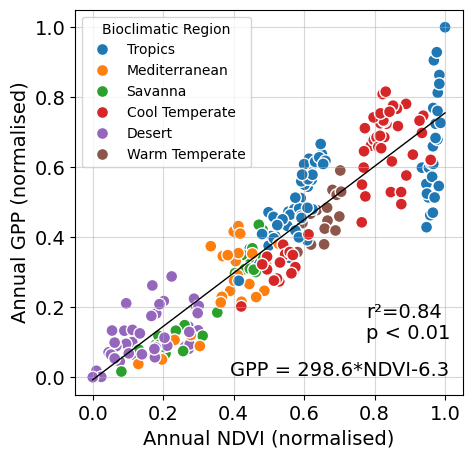

In [11]:
font=14
fig,ax = plt.subplots(1,1, figsize=(5,5))
varx='NDVI_normalised'
vary='GPP_normalised'

obs,pred = gdf_ts['NDVI'].values, gdf_ts['GPP_SOLO_EC'].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
r2 = r_value**2

sb.scatterplot(data=gdf_ts, y=vary, x=varx,  hue='Bioclimatic Region', s=75, lw=1, ax=ax, legend=True) #
sb.regplot(data=gdf_ts, y=vary,x=varx, scatter=False, color='black', line_kws={'linewidth':'1'}, ax=ax, ci=None)
# sb.regplot(data=gdf_ts, y=vary, x=vary, color='black', scatter=False,ci=None, line_kws={'linestyle':'dashed'}, ax=ax)
ax.set_title(None)
ax.set_xlabel('Annual NDVI (normalised)', fontsize=font)
ax.set_ylabel('Annual GPP (normalised)',fontsize=font)
ax.grid(alpha=0.5)

ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)

ax.text(.75, .2, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
        transform=ax.transAxes, fontsize=font)
ax.text(.75, .145, 'p < 0.01',
        transform=ax.transAxes, fontsize=font)
# ax.text(.75, .085, 'N={:.3g}'.format(len(gdf_ts)),
#         transform=ax.transAxes, fontsize=font)

ax.text(.4, .05, f'GPP = {slope:.1f}*NDVI{intercept:.2g}'.format(len(gdf_ts)),
        transform=ax.transAxes, fontsize=font)

ax.tick_params(axis='x', labelsize=font)
ax.tick_params(axis='y', labelsize=font)

fig.savefig('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AnnualGPP_vs_annualNDVI_bioclim.png',
               bbox_inches='tight', dpi=300)